[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sadeghkarimpouli/family_based_features/blob/main/Kahramanmaras_Family_clustering.ipynb)

In [ ]:
!pip install pandas numpy matplotlib matplotlib_scalebar cartopy pyproj geopandas shapelyv

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import cartopy.crs as ccrs
from pyproj import Transformer
import geopandas as gpd
from shapely.geometry import box
from matplotlib.collections import LineCollection

In [ ]:
!git clone https://github.com/sadeghkarimpouli/family_based_features.git
%cd family_based_features

import sys
import os 

sys.path.append(os.getcwd())

# Import from util
from util.Create_families import Create_families
from util.Cluster_families import Cluster_families

In [ ]:
n_clusters = 4 # Specify the desired number of clusters
clustering_method = 'kmeans' # Select a clustering method: 'kmeans', 'ward'
family_feature_flag = 'both' # Select which types of features are ssined to each family: flag = 'str': structural features, 'node': Event-based features, 'both': both features

print(f'Family-based features will be categorizing using {clustering_method} method with {n_clusters} categories.')

Family-based features will be categorizing using kmeans method with 4 categories.


In [ ]:
# Required files:
# Event-based fetures
df_feat_file_path = "Data/Kahramanmaras_processed_Event_feature_W15_30_S17_33.csv"
# Parent of each event based on nearest-neighbor distance
df_parents_file_path = "Data/Kahramanmaras_Parents.csv"
# Catalog data
catalog_file_path = "Data/Kahramanmaras_Cat.csv"  

# Load data
features = pd.read_csv(df_feat_file_path)
df_parents = pd.read_csv(df_parents_file_path)
catalog_data = pd.read_csv(catalog_file_path)
# Convert time
catalog_data['Time_date'] = catalog_data['Time[d.s]'].apply(lambda x: pd.Timestamp.fromordinal(int(x)) + pd.Timedelta(days=x % 1))

print('All data has been successfully uploaded.')

All data has been successfully uploaded.


In [ ]:
# Creat all families
# undisered_features is a list of prefixes of features that user wants to remove them from calculation
All_f, e_feat, time_column = Create_families(features, df_parents, catalog_data, undisered_features = ['enum'])
# Perform clustering
labels, feature_matrix, cluster_centroids = Cluster_families(All_f, catalog_data=catalog_data, e_feat = e_feat, 
                                                           n_clusters=n_clusters, method = clustering_method, family_feature_flag = family_feature_flag)
labels[time_column.idxmin()] = 0

print('All families have been successfully created and categorized.')

All families have been successfully created and categorized.


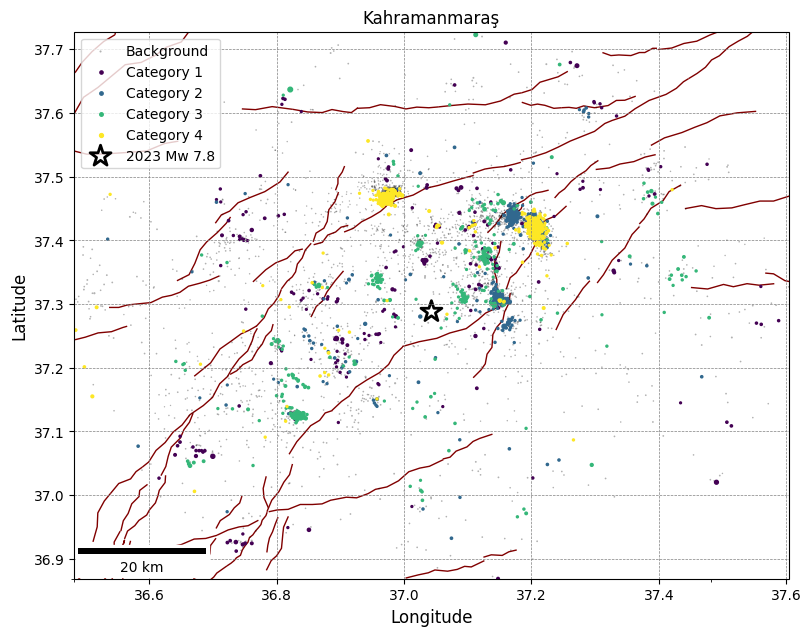

In [ ]:
# Map (spatial) view of categories.

# Define the UTM and WGS84 coordinate systems
utm_zone = 37  

utm_crs = f"EPSG:326{utm_zone}"  # WGS84 UTM for the northern hemisphere
wgs84_crs = "EPSG:4326"  # WGS84 lat/lon

# Create a Transformer object
transformer = Transformer.from_crs(utm_crs, wgs84_crs, always_xy=True)

# Transform UTM coordinates to lat/lon
catalog_data['lon'], catalog_data['lat'] = transformer.transform(catalog_data['UTM_Easting[m]'].values, catalog_data['UTM_Northing[m]'].values)

# Create map
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
ax = fig.add_subplot(projection=ccrs.PlateCarree())
norm = mcolors.Normalize(vmin=0, vmax=n_clusters-1)  # Normalizer for labels 
colormap = cm.viridis  # Choose a colormap (e.g., viridis, plasma, etc.)

ax.set_extent([catalog_data['lon'].min(), catalog_data['lon'].max(), 
               catalog_data['lat'].min(), catalog_data['lat'].max()], crs= ccrs.PlateCarree())

def read_fallas():
    data_arrays = []
    current_array = []
    filtered_arrays = []
    with open('Data/faults_MTA_new.txt', 'r') as file:
        for line in file:
            line = line.strip()
            if line:
                if '>' in line:
                    if current_array:
                        current_array = np.array(current_array)
                        if np.any((np.array(current_array[:, 0]) >= 34) & (
                                np.array(current_array[:, 0]) <= 40) & (np.array(current_array[:, 1]) >= 36.5) & (
                                          np.array(current_array[:, 1]) <= 39)):
                            filtered_arrays.append(current_array)
                    current_array = []
                else:
                    lon, lat = map(float, line.split('\t'))
                    current_array.append((lon, lat))
    return filtered_arrays

# Read fault traces
fault_traces = read_fallas()

subset_gdf = gpd.read_file('Data/AFEAD_v2022/AFEAD_v2022_subset.shp')
 ## define the boundaries of the figure
ll, rr, dd, uu = 36.47, 37.60, 36.87, 37.77
if True:
            ## bounding box to cut Zelenin Fault Dataset to only the region we are interested in (EAFZ)
            bounding_box = box(ll, dd, rr, uu)

            # Filter the GeoDataFrame to only include geometries that intersect with the bounding box
            subset_gdf = subset_gdf[subset_gdf.geometry.intersects(bounding_box)]

            # Now do the same for the Zelenin et al dataset
            subset_lines = []
            subset_lines_thick = []

            for n, row in subset_gdf.iterrows():
                x, y = row.geometry.xy  # Extract X (longitude) and Y (latitude) coordinates

                line_segment = np.column_stack([x, y])  # Convert to (N, 2) format
                # if row.ZONE_NAME == 'East Anatolian' and row.FAULT_ID != 25077: # we don't want fault segment 25077!
                #     subset_lines_thick.append(line_segment)
                # else:
                #     subset_lines.append(line_segment)
                subset_lines.append(line_segment)
            lc_thick = LineCollection(subset_lines_thick, color='maroon', linewidth=1, linestyle='-', zorder=1)
            lc_thin = LineCollection(subset_lines, color='maroon', linewidth=1, linestyle='-', zorder=1)

            ax.add_collection(lc_thick)
            ax.add_collection(lc_thin)

size_scale = 3.5

ax.scatter(
    catalog_data['lon'], catalog_data['lat'], 
    s=np.exp(catalog_data['Magnitude'].values/size_scale),
    c='k', marker='o', alpha=0.3, edgecolors='none', label='Background'
)

for i_c in range(n_clusters):
    lon_i = []
    lat_i = []
    m_i = []
    for i in np.where(labels==i_c)[0]:
        g_i = np.array(list(All_f[i]))
        lon_i += list(catalog_data[catalog_data['GENIE_ID'].isin(g_i)]['lon'].values)
        lat_i += list(catalog_data[catalog_data['GENIE_ID'].isin(g_i)]['lat'].values)
        m_i += list(catalog_data[catalog_data['GENIE_ID'].isin(g_i)]['Magnitude'].values)
    ax.scatter(
        lon_i, lat_i, s=np.exp(np.array(m_i)/size_scale*2),
        color=colormap(norm(labels[i])), label=f'Category {i_c+1}', #alpha=0.3, edgecolors='none'
        )

ax.scatter(37.043, 37.288, s=250, marker='*', color='b', facecolors='None', edgecolors='k', lw = 2, label='2023 Mw 7.8')
ax.set_xticks(np.arange(catalog_data['lon'].min(), catalog_data['lon'].max(), 1), minor=True)  # Adjust tick intervals based on your region
ax.set_yticks(np.arange(catalog_data['lat'].min(), catalog_data['lat'].max(), 1), minor=True)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.grid(color="gray", linestyle="--", linewidth=0.5)
ax.set_title('Kahramanmaraş')
# Add a scale bar
scalebar = ScaleBar(100, location="lower left", scale_loc="bottom", units="km")  # Adjust units as needed
ax.add_artist(scalebar)

ax.legend()

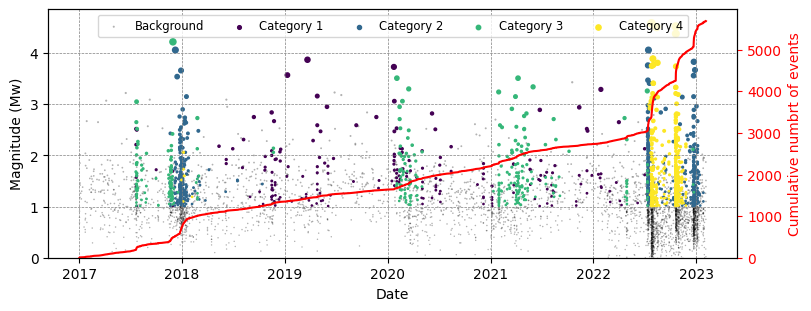

In [ ]:
# Plot categories in time scale

fig = plt.figure(figsize=(8, 3), constrained_layout=True)
ax = fig.add_subplot()

norm = mcolors.Normalize(vmin=0, vmax=n_clusters-1)  # Normalizer for labels 
colormap = cm.viridis  # Choose a colormap (e.g., viridis, plasma, etc.)
size_scale = 3.5 # Control event size

ax.scatter(
    catalog_data['Time_date'], catalog_data['Magnitude'], s=np.exp(catalog_data['Magnitude'].values/size_scale),
    c='k', marker='o', alpha=0.3, edgecolors='none', label='Background',
)

for i_c in range(n_clusters):
    t_i = []
    m_i = []
    for i in np.where(labels==i_c)[0]:
        g_i = np.array(list(All_f[i]))
        t_i += list(catalog_data[catalog_data['GENIE_ID'].isin(g_i)]['Time_date'].values)
        m_i += list(catalog_data[catalog_data['GENIE_ID'].isin(g_i)]['Magnitude'].values)
    ax.scatter(
        t_i, m_i, s=np.exp(np.array(m_i))/size_scale,
        color=colormap(norm(labels[i])), label=f'Category {i_c+1}', 
        )
    
ax2=ax.twinx()
p2, = ax2.plot(catalog_data['Time_date'], np.cumsum(np.ones(catalog_data.shape[0])), c='r')
ax2.yaxis.label.set_color(p2.get_color())
ax2.tick_params(axis='y', colors=p2.get_color())
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.), ncol=5, fontsize='small')
ax.xaxis.set_major_locator(mdates.YearLocator())  # Locator for every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as year
ax.set_xlabel('Date')
ax.set_ylabel('Magnitude (Mw)')
ax2.set_ylabel('Cumulative numbrt of events')
ax.set_ylim(0,)
ax2.set_ylim(0,)
ax.grid(color="gray", linestyle="--", linewidth=0.5)
plt.show() 

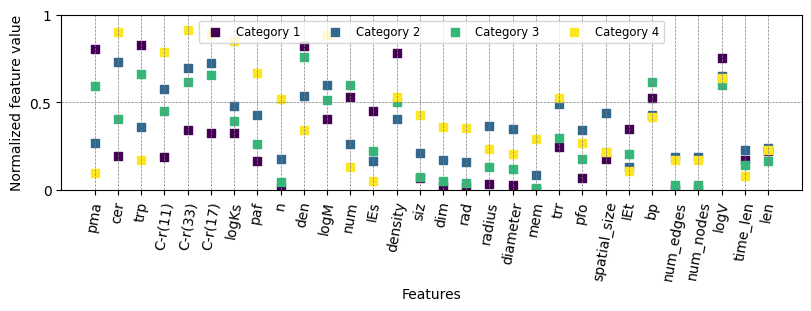

In [ ]:
# Plot Family-based features values (normalized) in Categories centers.
# This plot can be used to underestand the categories physically.

fig = plt.figure(figsize=(8, 3), constrained_layout=True)
ax = fig.add_subplot()

norm = mcolors.Normalize(vmin=0, vmax=n_clusters-1)  # Normalizer for labels 
colormap = cm.viridis  # Choose a colormap (e.g., viridis, plasma, etc.)

averaged_center = np.concatenate((cluster_centroids[:,:7], cluster_centroids[:,7:].reshape(cluster_centroids.shape[0], (cluster_centroids.shape[1]-7)//4, 4).mean(axis=2)), axis=1)
center_diff = [np.max(averaged_center[:,i])-np.min(averaged_center[:,i]) for i in range(averaged_center.shape[1])]
f_label = np.array(list(feature_matrix.columns[:7]) + [col.split('_')[0] for col in feature_matrix.columns[7::4]])
new_idx = np.flip(np.argsort(center_diff)).astype(int)
averaged_center = averaged_center[:,list(new_idx)]
f_label = f_label[list(new_idx)]

for i in range(n_clusters):
    ax.scatter(np.arange(len(f_label)), averaged_center[i,:], marker='s', color=colormap(norm(i)), label=f'Category {i+1}')

ax.set_ylabel('Normalized feature value')
ax.set_yticks([0,0.5,1], [0,0.5,1])
ax.set_ylim(0,1)
ax.set_xticks(np.arange(len(f_label)), f_label, rotation=80)
ax.set_xlabel('Features')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.), ncol=5, fontsize='small')
ax.grid(color="gray", linestyle="--", linewidth=0.5)